In [598]:
import sleeper_wrapper
from sleeper_wrapper import Stats
from requests import get, post
import pandas as pd
from yahoo_oauth import OAuth2
import yahoo_fantasy_api as yfa
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [1651]:
sc = OAuth2(None, None, from_file = 'oauth2.json')

[2023-12-05 12:32:20,797 DEBUG] [yahoo_oauth.oauth.__init__] Checking 
[2023-12-05 12:32:20,800 DEBUG] [yahoo_oauth.oauth.token_is_valid] ELAPSED TIME : 11258.99851322174
[2023-12-05 12:32:20,801 DEBUG] [yahoo_oauth.oauth.token_is_valid] TOKEN HAS EXPIRED
[2023-12-05 12:32:20,802 DEBUG] [yahoo_oauth.oauth.refresh_access_token] REFRESHING TOKEN


# Get all fantasy football data using yfa api

In [1652]:
gm = yfa.Game(sc, 'nfl')
leagues = gm.league_ids()
lg = gm.to_league('423.l.658258')
teamkey = lg.team_key()
team = lg.to_team(teamkey)
start_week = 14
week = 14

In [1655]:
def get_all_team_rosters(lg, week):
    # Get the number of teams in the league
    num_teams = len(lg.teams())

    # Initialize an empty DataFrame to hold all rosters
    all_rosters_df = pd.DataFrame()

    # Iterate through each team
    for num in range(1, num_teams + 1):
        # Construct the team key
        teamkey = f'{lg.league_id}.t.{num}'

        # Get the roster for the team
        roster = lg.to_team(teamkey).roster(week = week)
        # Convert the roster to a DataFrame
        roster_df = pd.DataFrame(roster)

        # Add team number and owner name to the DataFrame
        roster_df['team_id'] = lg.teams()[teamkey]['team_id']
        roster_df['team_name'] = lg.teams()[teamkey]['name']

        # Append the team's roster DataFrame to the all_rosters DataFrame
        all_rosters_df = pd.concat([all_rosters_df, roster_df], ignore_index=True)
        all_rosters_df['player_id'] = all_rosters_df['player_id'].astype('str')

    return all_rosters_df

In [1656]:
all_rosters = get_all_team_rosters(lg, week = week)

# Load in player projections from sleeper

In [1614]:
player_ids = pd.read_csv('player_ids.csv')
player_ids['sleeper_id'] = player_ids['sleeper_id'].astype('str')
player_ids['yahoo_id'] = player_ids['yahoo_id'].fillna(0).astype(int).astype('str')

## Get remaining projections

In [1615]:
stats = Stats()

def get_stats_for_weeks(start_week, end_week, season_type, year, stat_type = 'projections'):
    # Start week is current week
    # Initialize an empty list to store DataFrames
    # gets all NFL players in the Sleeper system
    # players = sleeper_wrapper.Players()
    # all_players = players.get_all_players()
    # players_df = pd.DataFrame.from_dict(all_players, orient='index')
    # players_df['yahoo_id'] = players_df['yahoo_id'].fillna(0).astype(int).astype('str')
    # Loop through each week from start_week to end_week
    if stat_type == 'projections':
        dfs = []
        for week in range(start_week, end_week + 1):
            # Retrieve the projections for the given week
            week_projections = stats.get_week_projections(season_type, year, week)

            # Convert the projections to a DataFrame
            df_week = pd.DataFrame.from_dict(week_projections, orient='index')

            df_week.index.name = 'player_id'
            df_week.reset_index(inplace=True)

            # Add a column to indicate the week
            df_week['week'] = week

            # Append the DataFrame to the list
            dfs.append(df_week)
    elif stat_type == 'stats':
        dfs = []
        for week in range(1, start_week):
            # Retrieve the projections for the given week
            week_stats = stats.get_week_stats(season_type, year, week)

            # Convert the projections to a DataFrame
            df_week = pd.DataFrame.from_dict(week_stats, orient='index')

            df_week.index.name = 'player_id'
            df_week.reset_index(inplace=True)

            # Add a column to indicate the week
            df_week['week'] = week

            # Append the DataFrame to the list
            dfs.append(df_week)

    # Combine all DataFrames into one
    combined_df = pd.concat(dfs, axis=0)

    # Reset the index of the combined DataFrame
    combined_df.reset_index(drop=True, inplace=True)
    combined_df=combined_df.rename(columns={'player_id':'sleeper_id'})
    # combined_df=combined_df.merge(players_df[['player_id', 'full_name']], on = 'player_id', how = 'inner')
    return combined_df

# Example usage
season_type = 'regular'
year = 2023
end_week = 17

### Run the code

In [1616]:
combined_projections = get_stats_for_weeks(start_week, end_week, season_type, year, stat_type = 'projections')
combined_stats = get_stats_for_weeks(start_week, end_week, season_type, year, stat_type='stats')

# Create an imputation function

If a player doesn't have a full lineup, we should impute the empty spots with an average of the best available players on the waiver wire. To do this, we will pull the available players from yahoo, join this to the sleeper projections, group by position, and select the top n players to find the average of.

# Get the yahoo free agents

In [1617]:
free_agents = {}
positions = lg.positions()
positions_list = list(positions.keys())

for position in positions_list:
    if position not in ['BN', 'W/R/T', 'IR']:  # Exclude 'BN' (Bench) position
        # Get the list of free agents for the position
        agents = lg.free_agents(position)
        # Append each agent to the free_agents dictionary
        for agent in agents:
            free_agents[agent['player_id']] = agent

# Add players from waivers
waiver_players = lg.waivers()
for player in waiver_players:
    free_agents[player['player_id']] = player

# Convert to DataFrame
import pandas as pd
free_agents_df = pd.DataFrame.from_dict(free_agents, orient='index')
free_agents_df = free_agents_df.rename(columns={'player_id':'yahoo_id'})
free_agents_df['yahoo_id'] = free_agents_df['yahoo_id'].astype('str')

In [1618]:
# Merge yahoo free agents with id map to get possible matches with sleeper projections
yahoo_merged = free_agents_df.merge(player_ids[['sleeper_id', 'yahoo_id', 'yahoo_name']], on = 'yahoo_id', how = 'inner')

# Merge this with sleeper

In [1619]:
proj_col_to_select = ['sleeper_id', 'pts_std', 'pts_ppr', 'pts_half_ppr', 'week']
proj_subset = combined_projections[proj_col_to_select]

In [1620]:
free_agents_df = yahoo_merged.merge(proj_subset, on = 'sleeper_id', how = 'left')

### Now make the imputation function

In [1621]:
def calculate_top_n_averages(df, scoring_type, positions_of_interest, n=5):
    # Define the positions to calculate averages for
    position_averages = {}
    for position in positions_of_interest:
        # Filter the DataFrame for the specific position
        filtered_df = df[df['eligible_positions'].apply(lambda x: position in x)]

        # Custom function to calculate the mean of top n players per week
        def top_n_mean(group):
            sorted_group = group.sort_values(ascending=False)
            return sorted_group.head(n).mean()

        # Group by week and apply the custom function
        averages = filtered_df.groupby('week')[scoring_type].apply(top_n_mean)

        position_averages[position] = averages

    return position_averages
positions_of_interest = [key for key in positions.keys() if key not in ['BN', 'IR']]
# Example usage
scoring_type = 'pts_ppr'  # Choose 'pts_std', 'pts_ppr', or 'pts_half_ppr'
imputable_evs = calculate_top_n_averages(free_agents_df, scoring_type, positions_of_interest, n = 2)


# Merge the data together. First, merge to the player_ids file, then to the roster file above.

In [1622]:
merged = combined_projections.merge(player_ids[['sleeper_id', 'yahoo_id', 'yahoo_name']], on = 'sleeper_id', how = 'inner')

In [1623]:
final_merged = merged.merge(all_rosters, left_on = 'yahoo_id', right_on = 'player_id', how = 'right')

# Now that we have the merged data, look at the standings data

In [1624]:
# Assuming lg.standings() returns the standings
standings = lg.standings()


In [1625]:
# Convert standings to DataFrame
standings_df = pd.DataFrame(standings)

# Normalize the nested dictionaries in the 'outcome_totals' and 'streak' columns
# This will create separate columns for each key in these dictionaries
outcome_totals_df = pd.json_normalize(standings_df['outcome_totals'])
streak_df = pd.json_normalize(standings_df['streak'])

# Drop the original nested columns from standings_df
standings_df.drop(columns=['outcome_totals', 'streak'], inplace=True)

# Concatenate the flattened columns back into the original DataFrame
standings_df = pd.concat([standings_df, outcome_totals_df, streak_df], axis=1)
standings_df['team_id'] = standings_df['team_key'].str.extract(r'\.t\.(\d+)$')
standings_df['wins'] = standings_df['wins'].astype('int')
standings_df['losses'] = standings_df['losses'].astype('int')
standings_df['percentage'] = standings_df['percentage'].astype('float')
standings_df['points_for'] = standings_df['points_for'].astype('float')
standings_df['points_against'] = standings_df['points_against'].astype('float')
standings_df['rank'] = standings_df['rank'].astype('int')
standings_df['playoff_seed'] = standings_df['playoff_seed'].astype('int')
standings_df['value'] = standings_df['value'].astype('int')

# Load the matchups data

Get the remaining matchups in a dictionary of dictionaries. It will be len(dict) = how many weeks there are left.

This way, we only call the lg.matchups() once.

In [1626]:
rest_of_matchups_dict = {str(i):lg.matchups(week = i) for i in range(13, 15)}


# Process the season stats data

In [1627]:
def calculate_dist_parameters(df, scoring_type):
    # Grouping by player_id and calculating mean and variance
    grouped_stats = df.groupby('sleeper_id')[scoring_type].agg(['mean', 'std']).reset_index()

    return grouped_stats[['sleeper_id', 'mean', 'std']]

# Example usage:
stats_subset = combined_stats[['sleeper_id', 'week', 'pts_std', 'pts_half_ppr', 'pts_ppr']][~combined_stats['pts_std'].isna() & ~combined_stats['sleeper_id'].str.startswith('TEAM_')]

# To get the mean and variance for standard points (pts_std)
result_std = calculate_dist_parameters(stats_subset, 'pts_std')

# For half PPR points (pts_half_ppr)
result_half_ppr = calculate_dist_parameters(stats_subset, 'pts_half_ppr')

# For PPR points (pts_ppr)
result_ppr = calculate_dist_parameters(stats_subset, 'pts_ppr')


# Now that we have the future and past data, we can join the two

### I. Next steps: 
#### 1. Join datasets

#### 2. optimize a lineup. Sort the players on a roster to have the highest EV points.

#### 3. Process: We have projected points, generate a random gamma number that simulates how many points they score. 

In [1628]:
def join_projections_and_stats(projections_df, stats_df, scoring_type = 'pts_half_ppr'):
    # scoring type = 'pts_std', 'pts_half_ppr', or 'pts_std'
    stats_subset = stats_df[['sleeper_id', 'week', 'pts_std', 'pts_half_ppr', 'pts_ppr']][~stats_df['pts_std'].isna() & ~stats_df['sleeper_id'].str.startswith('TEAM_')]
    results_df = calculate_dist_parameters(stats_subset, scoring_type)
    merged = projections_df.merge(results_df, on = 'sleeper_id', how = 'left')
    return merged

In [1629]:
p_and_s_merged = join_projections_and_stats(final_merged, combined_stats, scoring_type = 'pts_half_ppr')

# Set optimal lineups

In [1630]:
def set_optimal_lineup(df, roster_specs, scoring_system):
    # Initialize a column for optimal_position
    df['optimal_position'] = 'Bench'  # Default to bench

    # Iterate over each team and week
    for (team, week) in df.groupby(['team_name', 'week']).groups.keys():
        team_week_df = df[(df['team_name'] == team) & (df['week'] == week)].copy()

        # Initialize a dictionary to track positions needed
        positions_needed = {pos: specs['count'] for pos, specs in roster_specs.items() if specs['is_starting_position']}

        # First, assign players to unique positions
        for pos in positions_needed.keys():
            eligible_players = team_week_df[team_week_df['eligible_positions'].apply(lambda x: x == [pos])]
            for idx, player in eligible_players.iterrows():
                if positions_needed[pos] > 0:
                    team_week_df.at[idx, 'optimal_position'] = pos
                    positions_needed[pos] -= 1

        # Now assign players to shared positions based on highest points
        for pos, count in positions_needed.items():
            while count > 0:
                eligible_players = team_week_df[(team_week_df['optimal_position'] == 'Bench') & 
                                           (team_week_df['eligible_positions'].apply(lambda x: pos in x))]
                if not eligible_players.empty:
                    highest_scoring_player = eligible_players.sort_values(by=scoring_system, ascending=False).iloc[0]
                    team_week_df.at[highest_scoring_player.name, 'optimal_position'] = pos
                    count -= 1
                else:
                    break

        # Update the main dataframe
        df.update(team_week_df)
    return df


In [1631]:
optimal_lineups_df = set_optimal_lineup(p_and_s_merged, lg.positions(), 'pts_half_ppr')


In [1632]:
cols_to_select = ['eligible_positions',
 'name',
 'optimal_position',
 'player_id',
 'std',
 'selected_position',
 'sleeper_id',
 'status',
 'team_id',
 'team_name',
 'week',
 'yahoo_id',
 'pts_half_ppr',
 'pts_ppr',
 'pts_std']

week_df = optimal_lineups_df[cols_to_select]

# Create a function to expand the eligible positions into separate rows
def expand_eligible_positions(row):
    return [(row['std'], pos) for pos in row['eligible_positions']]

# Apply the function and create a new DataFrame
expanded_rows = week_df[week_df['optimal_position'] == 'Bench'].apply(expand_eligible_positions, axis=1).explode()
expanded_df = pd.DataFrame(expanded_rows.tolist(), columns=['std', 'position'])

# Filter for specific positions
filtered_df = expanded_df[expanded_df['position'].isin(positions_of_interest)]

# Group by position and calculate the mean standard deviation
imputable_stds = filtered_df.groupby('position')['std'].mean()

# Build the simulation

# Building the sim out

In [1633]:
required_positions = {key: value['count'] * value['is_starting_position'] for key, value in positions.items() if value['is_starting_position']}

In [1634]:
def find_missing_roster_spots(week_df, team_id):
    # Define the required positions in the lineup
    required_positions = ['QB', 'RB', 'WR', 'TE', 'W/R/T', 'DEF']
    
    # Filter the DataFrame for the specified team and week
    team_df = week_df[(week_df['team_id'] == team_id) & (week_df['week'] == week)]
    
    # Find which required positions are missing
    starting_positions = team_df['optimal_position'].tolist()
    missing_positions = [pos for pos in required_positions if pos not in starting_positions]

    return missing_positions

def simulate_week_points(week_df, week, imputable_evs, imputable_stds, scoring_type='pts_std', n=3, required_positions=required_positions):
    # required_positions is a dict with key = position, value = number of starting positions

    week_df = week_df.copy()
    week_df = week_df.loc[(week_df['week'] == week) & (week_df['optimal_position'] != 'Bench')]

    # Simulate points for each player
    week_df['simulated_points'] = np.random.normal(week_df[scoring_type], week_df['std'])

    # Handle NaN values
    week_df['simulated_points'] = week_df['simulated_points'].fillna(0)

    # Initialize missing_data DataFrame
    missing_data = []

    # Find missing positions for all teams
    all_teams = week_df['team_id'].unique()
    for team_id in all_teams:
        team_data = week_df[week_df['team_id'] == team_id]
        
        # Check for each required position
        for pos, required_count in required_positions.items():
            # Filter team data for this position and check the count and NaNs
            na_missing = team_data[(team_data['optimal_position'] == pos)][scoring_type].isna().sum()
            empty_missing = team_data[(team_data['optimal_position'] == pos)][scoring_type].empty
            
            # Check if there are missing spots or NaN points for this position
            missing_count = na_missing + empty_missing
            if missing_count > 0:
                # Get imputable EV and STD for the position and week
                ev = imputable_evs[pos][week]
                std = imputable_stds[pos]
                
                # Generate simulated points for each missing spot
                for _ in range(missing_count):
                    simulated_points = max(np.random.normal(ev, std), 0)
                    missing_data.append({'team_id': team_id, 'total_points': simulated_points})

    missing_data = pd.DataFrame(missing_data)
    # Group by team and sum points
    team_points = week_df.groupby(['team_id', 'team_name'])['simulated_points'].sum().reset_index()
    team_points.columns = ['team_id', 'team_name', 'total_points']

    # Merge and update total points if there are missing data
    if not missing_data.empty:
        missing_data_agg = missing_data.groupby('team_id')['total_points'].sum().reset_index()
        team_points = pd.merge(team_points, missing_data_agg, on='team_id', how='left')
        team_points = team_points.fillna(0)
        team_points['total_points'] = team_points['total_points_x'] + team_points['total_points_y']
        team_points = team_points.drop(['total_points_x', 'total_points_y'], axis = 1)

    return team_points

# np.random.seed(248)

# Example usage
scoring_type = 'pts_half_ppr'
team_points = simulate_week_points(week_df, week, imputable_evs, imputable_stds,
                                   scoring_type='pts_half_ppr', n=3, required_positions=required_positions)


In [1635]:
def simulate_week_matchups(week_df, week, scoring_type, standings_df, rest_of_matchups_dict,
                           imputable_evs, imputable_stds, n, required_positions):
    matchups_dict = rest_of_matchups_dict[str(week)]
    standings_df = standings_df.copy(deep=True)
    team_points = simulate_week_points(week_df, week, imputable_evs, imputable_stds,
                                   scoring_type, n, required_positions=required_positions)

    for i in range(6):  # Assuming there are 6 matchups
        matchup_key = str(i)
        tm1 = matchups_dict['fantasy_content']['league'][1]['scoreboard']['0']['matchups'][matchup_key]['matchup']['0']['teams']['0']['team'][0][1]['team_id']
        tm2 = matchups_dict['fantasy_content']['league'][1]['scoreboard']['0']['matchups'][matchup_key]['matchup']['0']['teams']['1']['team'][0][1]['team_id']

        # Get points for each team in the matchup
        tm1_points = team_points.loc[team_points['team_id'] == tm1, 'total_points'].values[0]
        tm2_points = team_points.loc[team_points['team_id'] == tm2, 'total_points'].values[0]

        # Compare points and update standings
        if tm1_points > tm2_points:
            standings_df.loc[standings_df['team_id'] == tm1, 'wins'] += 1
            standings_df.loc[standings_df['team_id'] == tm2, 'losses'] += 1
            if standings_df.loc[standings_df['team_id'] == tm1, 'type'].values[0] == 'win':
                standings_df.loc[standings_df['team_id'] == tm1, 'value'] += 1
            else:
                standings_df.loc[standings_df['team_id'] == tm1, 'type'] = 'win'
                standings_df.loc[standings_df['team_id'] == tm1, 'value'] = 1
            if standings_df.loc[standings_df['team_id'] == tm2, 'type'].values[0] == 'loss':
                standings_df.loc[standings_df['team_id'] == tm2, 'value'] += 1
            else:
                standings_df.loc[standings_df['team_id'] == tm2, 'type'] = 'loss'
                standings_df.loc[standings_df['team_id'] == tm2, 'value'] = 1
        elif tm2_points > tm1_points:
            standings_df.loc[standings_df['team_id'] == tm2, 'wins'] += 1
            standings_df.loc[standings_df['team_id'] == tm1, 'losses'] += 1
            if standings_df.loc[standings_df['team_id'] == tm2, 'type'].values[0] == 'win':
                standings_df.loc[standings_df['team_id'] == tm2, 'value'] += 1
            else:
                standings_df.loc[standings_df['team_id'] == tm2, 'type'] = 'win'
                standings_df.loc[standings_df['team_id'] == tm2, 'value'] = 1
            if standings_df.loc[standings_df['team_id'] == tm1, 'type'].values[0] == 'loss':
                standings_df.loc[standings_df['team_id'] == tm1, 'value'] += 1
            else:
                standings_df.loc[standings_df['team_id'] == tm1, 'type'] = 'loss'
                standings_df.loc[standings_df['team_id'] == tm1, 'value'] = 1
        else:  # In case of a tie
            standings_df.loc[standings_df['team_id'] == tm1, 'ties'] += 1
            standings_df.loc[standings_df['team_id'] == tm2, 'ties'] += 1
            if standings_df.loc[standings_df['team_id'] == tm1, 'type'].values[0] == 'tie':
                standings_df.loc[standings_df['team_id'] == tm1, 'value'] += 1
            else:
                standings_df.loc[standings_df['team_id'] == tm1, 'type'] = 'tie'
                standings_df.loc[standings_df['team_id'] == tm1, 'value'] = 1
            if standings_df.loc[standings_df['team_id'] == tm2, 'type'].values[0] == 'tie':
                standings_df.loc[standings_df['team_id'] == tm2, 'value'] += 1
            else:
                standings_df.loc[standings_df['team_id'] == tm1, 'type'] = 'tie'
                standings_df.loc[standings_df['team_id'] == tm2, 'value'] = 1

        # Update points for and against
        standings_df.loc[standings_df['team_id'] == tm1, 'points_for'] += tm1_points
        standings_df.loc[standings_df['team_id'] == tm1, 'points_against'] += tm2_points
        standings_df.loc[standings_df['team_id'] == tm2, 'points_for'] += tm2_points
        standings_df.loc[standings_df['team_id'] == tm2, 'points_against'] += tm1_points
            
    # Update winning percentage and re-rank
    standings_df['percentage'] = (standings_df['wins'] + 0.5 * standings_df['ties']) / (standings_df['wins'] + standings_df['losses'] + standings_df['ties'])
    standings_df.sort_values(by=['percentage', 'points_for'], ascending=False, inplace=True)
    standings_df['rank'] = range(1, len(standings_df) + 1)
    standings_df['playoff_seed'] = range(1, len(standings_df) + 1)

    return standings_df

# Example usage
scoring_type = 'pts_half_ppr'
updated_standings = simulate_week_matchups(week_df, week, scoring_type, standings_df, rest_of_matchups_dict, imputable_evs,
                                           imputable_stds, n=3, required_positions=required_positions)

In [1638]:
def simulate_end_of_regular_season(week_df, initial_standings_df, scoring_type, rest_of_matchups_dict, num_playoff_teams, imputable_evs,
                                           imputable_stds, required_positions=required_positions, n=3, week=14):
    current_standings_df = initial_standings_df.copy()
    for week in range(week, 15):  # Weeks 12, 13, 14
        matchups_dict = rest_of_matchups_dict[str(week)]  # Retrieve matchups for the current week
        updated_standings_df = simulate_week_matchups(week_df, week, scoring_type, standings_df, rest_of_matchups_dict, imputable_evs,
                                           imputable_stds, n=3, required_positions=required_positions)

        # Prepare for the next iteration (if any)
        current_standings_df = updated_standings_df
        # Update current_week_df with data for the next week
        # current_week_df = <Code to get data for the next week>
    current_standings_df['made_playoffs'] = np.where(current_standings_df['playoff_seed'] <= num_playoff_teams, 1,
                                                     0)
    return current_standings_df

# Example usage
num_playoff_teams = 6
# Assuming 'initial_week_df' and 'initial_standings_df' are defined and 'lg' is the league object
final_regular_season_standings = simulate_end_of_regular_season(week_df, standings_df, scoring_type, rest_of_matchups_dict, num_playoff_teams, imputable_evs,
                                           imputable_stds, n=3, required_positions=required_positions, week=week)


In [1639]:
final_regular_season_standings

,team_key,name,rank,playoff_seed,points_for,points_against,wins,losses,ties,percentage,type,value,team_id,made_playoffs
1,423.l.658258.t.10,The William Bears,1,1,1446.357,1163.540,10,4,0,0.714,win,2,10,1
0,423.l.658258.t.1,Pancake Man,2,2,1444.707,1311.792,10,4,0,0.714,win,1,1,1
2,423.l.658258.t.9,Deevi from New Delhi,3,3,1404.067,1288.721,9,5,0,0.643,win,3,9,1
4,423.l.658258.t.6,Revenge szn ong,4,4,1430.575,1258.069,8,6,0,0.571,win,3,6,1
3,423.l.658258.t.8,Slim Pickens (,5,5,1399.741,1337.467,7,7,0,0.500,loss,3,8,1
5,423.l.658258.t.3,Tailgate szn,6,6,1379.652,1423.527,7,7,0,0.500,loss,1,3,1
6,423.l.658258.t.4,Joey sux I hate Joey,7,7,1319.280,1432.937,7,7,0,0.500,loss,2,4,0
7,423.l.658258.t.5,Cleveland Downs,8,8,1246.429,1369.435,7,7,0,0.500,loss,3,5,0
8,423.l.658258.t.12,Pietism,9,9,1201.395,1219.959,6,8,0,0.429,loss,1,12,0
9,423.l.658258.t.2,Big-Ten Bitches,10,10,1327.860,1368.256,5,9,0,0.357,win,2,2,0


## Run bracket

In [1640]:
import math

def set_up_bracket(final_standings, num_playoff_teams):
    num_teams = len(final_standings)
    sorted_standings = final_standings.sort_values(by='rank')

    # Top teams for winners bracket, remaining for losers bracket
    winners = sorted_standings.head(num_playoff_teams)['team_id'].tolist()
    losers = sorted_standings.tail(num_teams - num_playoff_teams)['team_id'].tolist()

    # Create initial winners bracket matchups
    winners_bracket = {
        'round_1': {
            'matchup_1': [winners[3], winners[4]],  # 4 vs 5
            'matchup_2': [winners[2], winners[5]],  # 3 vs 6
            'byes': [winners[0], winners[1]]       # 1 and 2
        },
        'round_2': {
            'matchup_1': [winners[0]],  # To be filled with winner of 4 vs 5 vs 1st seed
            'matchup_2': [winners[1]],  # To be filled with winner of 3 vs 6 vs 2nd seed
            'byes': []        # To be filled with losing teams from round 1
        },
        'round_3': {
            'championship': [],
            '3rd_place': [],   # To be filled with losing teams from round 2
            '5th_place': []    # Automatically filled with byes from round 2
        }
    }

    # Create initial losers bracket matchups
    losers_bracket = {
        'round_1': {
            'matchup_1': [losers[1], losers[2]],  # 8 vs 9
            'matchup_2': [losers[0], losers[3]],  # 7 vs 10
            'byes': [losers[5], losers[4]]      # 12 and 11
        },
        'round_2': {
            'matchup_1': [losers[5]],  # To be filled with loser of 8 vs 9 vs 12th seed
            'matchup_2': [losers[4]],  # To be filled with loser of 7 vs 10 vs 11th seed
            'byes': []        # To be filled with winning teams from round 1
        },
        'round_3': {
            'toilet_bowl': [], # To be filled with winning teams from round 2
            '9th_place': [],   # Automatically filled with byes from round 2
            '7th_place': []    # To be filled with losing teams from round 2
        }
    }
    final_placement = {i:[] for i in range(1, 13)}

    return {'winners': winners_bracket, 'losers': losers_bracket, 'final_placement':final_placement}


def generate_final_standings(brackets, simulated_points):
    # Create a dictionary to map team IDs to team names
    team_names = pd.Series(simulated_points['team_name'].values, index=simulated_points['team_id']).to_dict()

    final_standings = []

    # Iterate through final placements and assign standings
    for placement, teams in brackets['final_placement'].items():
        for team_id in teams:
            final_standings.append({
                'team_id': team_id,
                'team_name': team_names.get(team_id, 'Unknown Team'),
                'final_placement': int(placement)
            })

    # Convert to DataFrame and sort by final placement
    final_standings_df = pd.DataFrame(final_standings)
    final_standings_df = final_standings_df.sort_values(by='final_placement').reset_index(drop=True)
    final_standings_df['won_championship'] = np.where(final_standings_df['final_placement'] == 1, 1,
                                                      0)
    final_standings_df['is_toilet_loser'] = np.where(final_standings_df['final_placement'] == 12, 1,
                                                      0)
    return final_standings_df

def check_and_append(dict_entry, team):
    if team in dict_entry:
        1
    else:
        dict_entry.append(team)
        
def check_and_append(dict_entry, team):
    if team in dict_entry:
        1
    else:
        dict_entry.append(team)
def update_next_round(brackets, key, current_round, winner, loser, matchup_key):
    if current_round == 1:
        if key == 'winners':
            # Determine the next round matchup for the winner
            next_round_matchup = 'matchup_1' if matchup_key == 'matchup_1' else 'matchup_2'
            check_and_append(brackets[key]['round_2'][next_round_matchup], winner)
        if key == 'losers':
            # Determine the next round matchup for the winner
            next_round_matchup = 'matchup_1' if matchup_key == 'matchup_1' else 'matchup_2'
            check_and_append(brackets[key]['round_2'][next_round_matchup], loser) 
        # Update the loser to the next round's byes in winners bracket
        if key == 'winners':
            check_and_append(brackets[key]['round_2']['byes'], loser)
            check_and_append(brackets[key]['round_3']['5th_place'], loser)
        elif key == 'losers':
            check_and_append(brackets[key]['round_2']['byes'], winner)
            check_and_append(brackets[key]['round_3']['7th_place'], winner)

    elif current_round == 2:
        # Determine the next round's matchup for the winner
        if key == 'winners':
            check_and_append(brackets[key]['round_3']['championship'], winner)
            check_and_append(brackets[key]['round_3']['3rd_place'], loser)
        else:  # Losers bracket
            check_and_append(brackets[key]['round_3']['toilet_bowl'], loser)
            check_and_append(brackets[key]['round_3']['9th_place'], winner)
    elif current_round == 3:
        if key == 'winners':
            if matchup_key == 'championship':
                check_and_append(brackets['final_placement'][1], winner)
                check_and_append(brackets['final_placement'][2], loser)
            elif matchup_key == '3rd_place':
                check_and_append(brackets['final_placement'][3], winner)
                check_and_append(brackets['final_placement'][4], loser)
            elif matchup_key == '5th_place':
                check_and_append(brackets['final_placement'][5], winner)
                check_and_append(brackets['final_placement'][6], loser)
        if key == 'losers':
            if matchup_key == 'toilet_bowl':
                check_and_append(brackets['final_placement'][11], winner)
                check_and_append(brackets['final_placement'][12], loser)
            elif matchup_key == '7th_place':
                check_and_append(brackets['final_placement'][7], winner)
                check_and_append(brackets['final_placement'][8], loser)
            elif matchup_key == '9th_place':
                check_and_append(brackets['final_placement'][9], winner)
                check_and_append(brackets['final_placement'][10], loser)

def simulate_playoffs_12(week_df, start_week, scoring_type, final_standings, num_playoff_teams, imputable_evs, imputable_stds,
                                n, required_positions):
    brackets = set_up_bracket(final_standings, num_playoff_teams=num_playoff_teams)

    for week in range(start_week, start_week + 3):  # Weeks 15, 16, 17 for playoffs
        # Simulate points for the current week
        simulated_points = simulate_week_points(week_df, week, imputable_evs, imputable_stds,
                                   scoring_type, n, required_positions=required_positions)

        # Determine the current round based on the week
        current_round = week - start_week + 1

        # Process matchups for the current round
        for key in ['winners', 'losers']:
            round_key = f'round_{current_round}'
            if round_key in brackets[key]:
                for matchup_key, teams in brackets[key][round_key].items():
                    if matchup_key != 'byes' and len(teams) == 2:  # Actual matchup
                        team1_id, team2_id = teams
                        team1_points = simulated_points[simulated_points['team_id'] == team1_id]['total_points'].values[0]
                        team2_points = simulated_points[simulated_points['team_id'] == team2_id]['total_points'].values[0]

                        winner = team1_id if team1_points > team2_points else team2_id
                        loser = team2_id if winner == team1_id else team1_id

                        # Update next round's matchups based on current round's winner
                        update_next_round(brackets, key, current_round, winner, loser, matchup_key)
    final_standings_df = generate_final_standings(brackets, simulated_points)
    return brackets, final_standings_df


# Example usage
scoring_type = 'pts_half_ppr'
final_brackets, final_standings_playoffs = simulate_playoffs_12(week_df, 15, scoring_type=scoring_type, final_standings=final_regular_season_standings,
                                                                 imputable_evs=imputable_evs, imputable_stds=imputable_stds, required_positions=required_positions,n=3, num_playoff_teams=6)


# Finally, running the actual simulations

In [1641]:
def update_regular_season_stats(current_stats, new_data):
    for index, row in new_data.iterrows():
        team_id = row['team_id']
        if team_id not in current_stats:
            # If the team is not already in the stats, add it
            current_stats[team_id] = row
            current_stats[team_id]['best_playoff_seed'] = row['playoff_seed']
            current_stats[team_id]['worst_playoff_seed'] = row['playoff_seed']
            current_stats[team_id]['simulations_count'] = 1  # Initialize simulations count
        else:
            # Update existing stats with weighted averages and best/worst records
            for col in ['playoff_seed', 'points_for', 'points_against', 'wins', 'losses', 'ties', 'percentage']:
                current_stats[team_id][col] = (current_stats[team_id][col] * current_stats[team_id]['simulations_count'] + row[col]) / (current_stats[team_id]['simulations_count'] + 1)
            
            current_stats[team_id]['made_playoffs'] = (current_stats[team_id]['made_playoffs'] * current_stats[team_id]['simulations_count'] + row['made_playoffs']) / (current_stats[team_id]['simulations_count'] + 1)
            current_stats[team_id]['best_playoff_seed'] = min(current_stats[team_id]['best_playoff_seed'], row['playoff_seed'])
            current_stats[team_id]['worst_playoff_seed'] = max(current_stats[team_id]['worst_playoff_seed'], row['playoff_seed'])
            current_stats[team_id]['simulations_count'] += 1  # Increment simulations count
    return current_stats

def update_playoff_stats(current_stats, new_data):
    for index, row in new_data.iterrows():
        team_id = row['team_id']
        if team_id not in current_stats:
            # If the team is not already in the stats, add it
            current_stats[team_id] = row
            current_stats[team_id]['best_finish'] = row['final_placement']
            current_stats[team_id]['worst_finish'] = row['final_placement']
            current_stats[team_id]['simulations_count'] = 1  # Initialize simulations count
        else:
            # Update existing stats with weighted averages and best/worst finishes
            current_stats[team_id]['final_placement'] = (current_stats[team_id]['final_placement'] * current_stats[team_id]['simulations_count'] + row['final_placement']) / (current_stats[team_id]['simulations_count'] + 1)
            current_stats[team_id]['won_championship'] = (current_stats[team_id]['won_championship'] * current_stats[team_id]['simulations_count'] + row['won_championship']) / (current_stats[team_id]['simulations_count'] + 1)
            current_stats[team_id]['is_toilet_loser'] = (current_stats[team_id]['is_toilet_loser'] * current_stats[team_id]['simulations_count'] + row['is_toilet_loser']) / (current_stats[team_id]['simulations_count'] + 1)
            current_stats[team_id]['best_finish'] = min(current_stats[team_id]['best_finish'], row['final_placement'])
            current_stats[team_id]['worst_finish'] = max(current_stats[team_id]['worst_finish'], row['final_placement'])
            current_stats[team_id]['simulations_count'] += 1  # Increment simulations count
    return current_stats


def run_simulations(week_df, n, scoring_type, standings_df, rest_of_matchups_dict):
    # Initialize dictionaries to store cumulative stats
    regular_season_stats = {}
    playoff_stats = {}
    for _ in range(n):
        # Simulate the end of the regular season
        final_regular_season_standings = simulate_end_of_regular_season(week_df, standings_df, scoring_type, rest_of_matchups_dict, num_playoff_teams, imputable_evs,
                                           imputable_stds, n=3, required_positions=required_positions)
        # Update regular season stats with the latest simulation results
        regular_season_stats = update_regular_season_stats(regular_season_stats, final_regular_season_standings)

        # Simulate playoffs
        final_brackets, final_standings_playoffs = simulate_playoffs_12(week_df, 15, scoring_type=scoring_type, final_standings=final_regular_season_standings,
                                                                 imputable_evs=imputable_evs, imputable_stds=imputable_stds, required_positions=required_positions,n=3, num_playoff_teams=6)
        # Update playoff stats with the latest simulation results
        playoff_stats = update_playoff_stats(playoff_stats, final_standings_playoffs)

    # Convert the final stats dictionaries to DataFrames for easier analysis and export
    regular_season_stats_df = pd.DataFrame.from_dict(regular_season_stats, orient='index')
    cols_to_select2 = ['team_id', 'name', 'playoff_seed', 'points_for', 'points_against', 'wins', 'losses',
                       'ties', 'percentage', 'made_playoffs', 'best_playoff_seed', 'worst_playoff_seed']
    regular_season_stats_df = regular_season_stats_df[cols_to_select2]
    regular_season_stats_df = regular_season_stats_df.sort_values(by=['percentage', 'points_for'], ascending=False)
    playoff_stats_df = pd.DataFrame.from_dict(playoff_stats, orient='index')

    return regular_season_stats_df, playoff_stats_df


In [1643]:
# np.random.seed(248)
regular_season_stats_df, playoff_stats_df = run_simulations(week_df, 1000, scoring_type, standings_df, rest_of_matchups_dict)
regular_season_stats_df['made_playoffs'] = regular_season_stats_df['made_playoffs'] * 100
playoff_stats_df['won_championship'] = playoff_stats_df['won_championship'] * 100
playoff_stats_df['is_toilet_loser'] = playoff_stats_df['is_toilet_loser'] * 100

In [ ]:
regular_season_stats_df['name'] = regular_season_stats_df.apply(
    lambda row: row['name'] if row['team_id'] == '10' else f"Team {row['team_id']}", axis=1
)
playoff_stats_df['team_name'] = playoff_stats_df.apply(
    lambda row: row['team_name'] if row['team_id'] == '10' else f"Team {row['team_id']}", axis=1
)

In [1644]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
regular_season_stats_df

,team_id,name,playoff_seed,points_for,points_against,wins,losses,ties,percentage,made_playoffs,best_playoff_seed,worst_playoff_seed
10,10,The William Bears,1.722,1432.159,1166.482,9.529,4.471,0.000,0.681,100.000,1,3
1,1,Pancake Man,1.646,1438.900,1331.178,9.446,4.554,0.000,0.675,100.000,1,3
9,9,Deevi from New Delhi,3.325,1420.244,1315.582,8.558,5.442,0.000,0.611,100.000,1,6
3,3,Tailgate szn,5.392,1399.038,1417.720,7.554,6.446,0.000,0.540,75.000,3,8
5,5,Cleveland Downs,6.625,1288.646,1334.274,7.529,6.471,0.000,0.538,47.500,4,9
4,4,Joey sux I hate Joey,6.605,1322.222,1418.739,7.471,6.529,0.000,0.534,40.700,4,8
6,6,Revenge szn ong,5.906,1395.414,1300.286,7.471,6.529,0.000,0.534,54.300,3,8
8,8,Slim Pickens (,4.785,1426.602,1353.644,7.442,6.558,0.000,0.532,82.500,3,8
12,12,Pietism,8.994,1212.107,1218.309,6.419,7.581,0.000,0.459,0.000,8,9
7,7,We are the JIMBO,10.526,1162.345,1320.049,4.544,9.456,0.000,0.325,0.000,10,12


In [1645]:
playoff_stats_df.sort_values(by = ['won_championship', 'is_toilet_loser'], ascending=[False, True])

,team_id,team_name,final_placement,won_championship,is_toilet_loser,best_finish,worst_finish,simulations_count
10,10,The William Bears,2.397,35.500,0.000,1,6,1000
1,1,Pancake Man,2.749,19.700,0.000,1,6,1000
4,4,Joey sux I hate Joey,6.137,10.700,1.200,1,12,1000
9,9,Deevi from New Delhi,3.859,9.700,0.000,1,6,1000
3,3,Tailgate szn,5.210,8.800,2.100,1,12,1000
8,8,Slim Pickens (,4.929,7.400,2.200,1,12,1000
6,6,Revenge szn ong,6.280,5.100,5.800,1,12,1000
5,5,Cleveland Downs,6.799,3.100,6.500,1,12,1000
12,12,Pietism,9.412,0.000,17.000,7,12,1000
2,2,Big-Ten Bitches,9.924,0.000,20.000,7,12,1000


# Make charts!

We want to look at playoff likelihood, championship likelihood, toilet bowl likelihood, chance of championship given they make the playoffs, chance of toilet bowl given they miss the playoffs. most important matchup -- which matchup has the biggest effect on P(playoffs|win/loss)--will this always be the current matchup? projected playoff seed. violin plot of playoff seeds by team. 

## Create color map for each team

In [1646]:
# Assuming 'df' is your DataFrame and 'team_name' is the column with team names
team_names = playoff_stats_df['team_name'].unique()

# Generate a color palette with the same number of colors as teams
palette = sns.color_palette("tab10", n_colors=len(team_names))  # 'tab10' or any other palette

# Create a dictionary to map team names to colors
color_map = dict(zip(team_names, palette))

# Playoff chances by team

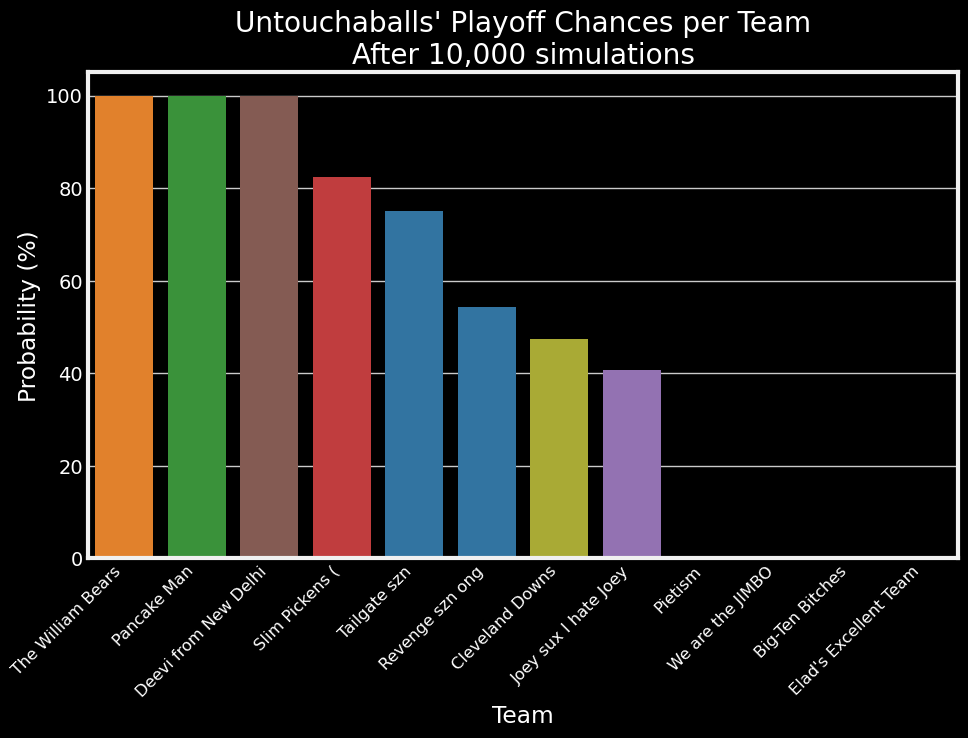

In [1647]:
# Set the style
plt.style.use('fivethirtyeight')

# Dark mode background
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='made_playoffs', data=regular_season_stats_df.sort_values('made_playoffs', ascending = False),
            palette=color_map, hue = 'name')
plt.title("Untouchaballs' Playoff Chances per Team\nAfter 10,000 simulations")
plt.xlabel('Team')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45,ha='right', fontsize='small')
plt.show()


# Championship Chances by Team

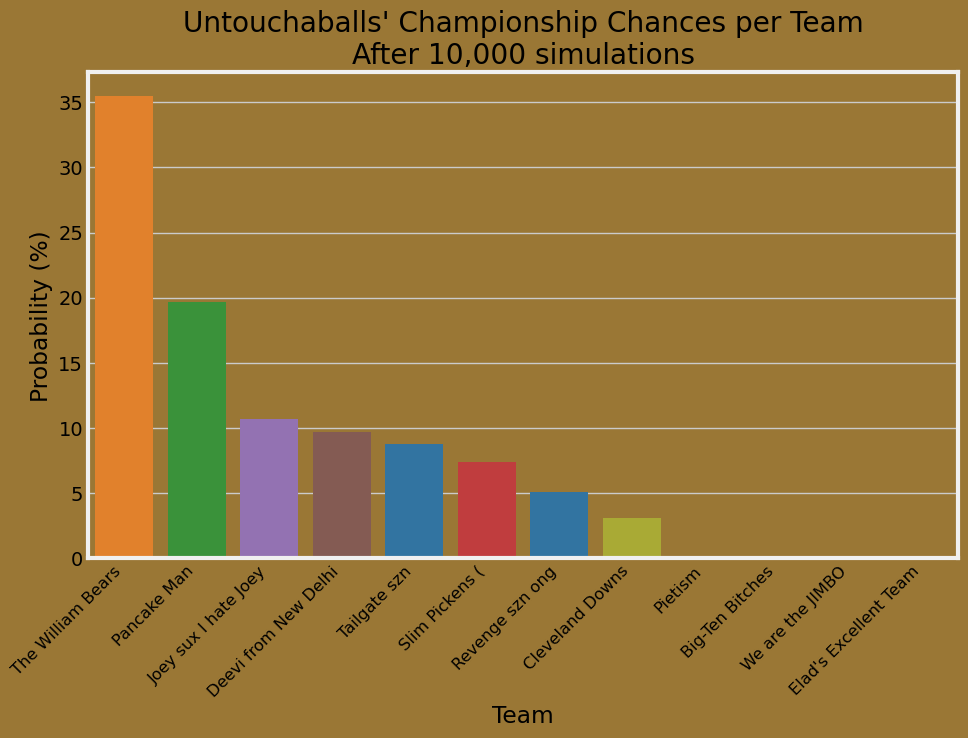

In [1648]:
# Set the style
plt.style.use('fivethirtyeight')

# Dark mode background
plt.rcParams['axes.facecolor'] = '#9A7735'
plt.rcParams['figure.facecolor'] = '#9A7735'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='won_championship', data=playoff_stats_df.sort_values(by = ['won_championship', 'is_toilet_loser'],
                                                                                   ascending=[False, True]),
             palette=color_map, hue = 'team_name')
plt.title("Untouchaballs' Championship Chances per Team\nAfter 10,000 simulations")
plt.xlabel('Team')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45,ha='right', fontsize='small')
plt.show()


# Toilet Bowl Chances

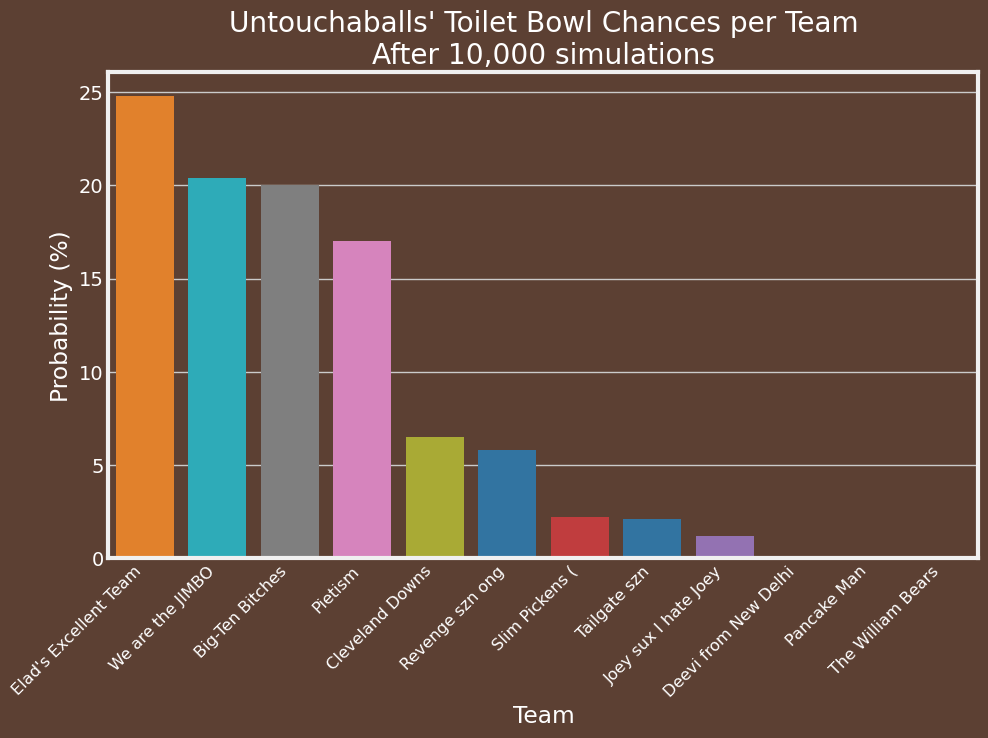

In [1650]:
# Set the style
plt.style.use('fivethirtyeight')

# Dark mode background
plt.rcParams['axes.facecolor'] = '#5C4033'
plt.rcParams['figure.facecolor'] = '#5C4033'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x='team_name', y='is_toilet_loser', data=playoff_stats_df.sort_values(by = ['is_toilet_loser', 'won_championship'],
                                                                                   ascending=[False, True]),
             palette=color_map, hue = 'team_name')
plt.title("Untouchaballs' Toilet Bowl Chances per Team\nAfter 10,000 simulations")
plt.xlabel('Team')
plt.ylabel('Probability (%)')
plt.xticks(rotation=45,ha='right', fontsize='small')
plt.show()
